# Icatibant lot 23 decomposition

This notebook shows how to perform spectral deconvolution using the FTIR tool suite developed by KBI Biopharma. 

The spectral deconvolution tools utilize the scipy solvers to deconvolute second derivative or fourier self deconvolution spectra using a guassian peak model. There are three parameters per peak (mean, height and width), and thus 36 inputs are present for a 12 peak reference set. The default peak definitions `yang_h20_2015` has 14 peaks, and thus 42 input parameters are present. The parameter space is very large, and thus different gradient based solvers are likely to converge to slightly different local minima. A least squares approach using a linear loss function `rho(z) = z` was used for decomposition


In [142]:
# imports
%matplotlib inline
import os
import pandas as pd
import numpy as np #import to take 2nd derivative as I don't think this occured, Jeff 2.28.2022 
import sys
sys.path.append("../")
import ftir.modeling.peak_fitting as peak_fitting
from ftir.modeling.buffer_subtraction import find_buffer_subtraction_constant, buffer_subtract
from ftir.modeling.peak_fitting import gaussian_minimize, gaussian_differential_evolution, gaussian_least_squares
from ftir.modeling.peak_fitting import secondary_structure, create_fit_plots, gaussian_list, sd_baseline_correction
# from ftir.modeling.peak_definitions import yang_h20_2015, dong_h2o_1990, yang_list
from ftir.io.utils import create_df_from_single_file


In [30]:
#local yang list,
yang_list = {
    'means': [1625, 1627, 1633, 1637, 1642, 1649, 1656, 1663, 1667, 1675, 1680,
              1685, 1692, 1696],
    'uncertainties': [(1622, 1625), (1625, 1629), (1631, 1635), (1636, 1640),
                      (1641, 1643), (1646, 1650), (1654, 1658), (1660, 1666),
                      (1666, 1668), (1674, 1676), (1678, 1682), (1683, 1687),
                      (1689, 1693), (1694, 1698)],
    'relative_uncertainties': [1, 2, 2, 2, 1, 2, 2, 3, 1, 1, 2, 2, 2, 2],
    'assignments': ['beta_sheet', 'beta_sheet', 'beta_sheet', '310_helix',
                    'unordered', 'alpha_helix', 'beta_turn', 'beta_turn',
                    'beta_sheet', 'beta_turn', 'beta_turn', 'beta_turn']}
                    
#local Cebe is a complete badass woman physicist professor list 
hu_Kaplan_Cebe_2006 = {
    'means': [1610, 1619, 1625, 1632,  1642, 1652, 1659, 1666.5, 1678, 1691, 1700],
    'uncertainties': [(1622, 1625), (1625, 1629), (1631, 1635), (1636, 1640),
                      (1641, 1643), (1646, 1650), (1654, 1658), (1660, 1666),
                      (1666, 1668), (1674, 1676), (1678, 1682), (1683, 1687),
                      (1689, 1693), (1694, 1698)],
    'relative_uncertainties': [5, 2.5, 2.5, 4.5, 4, 4, 3, 3.5, 7, 5, 3],
    'assignments': ['(Tyr) side chains/aggregate strands', 'aggregate beta-strand/beta_sheet(weak)', 
                    'intermolecular beta_sheet (strong)', 'intramolecular beta_sheet (strong)^b',
                    'random coils/extended', 'random coils', 'alpha-helices', 'turns',
                    'turns', 'turns', 'intermolecular beta_sheets (weak']}

In [3]:
os.getcwd()
os.path.abspath("../data/FTIRrawspectraUVmaskLeftside.csv")

'c:\\Users\\jrosh\\ftir_data_analytics\\data\\FTIRrawspectraUVmaskLeftside.csv'

In [12]:
# get the data
os.getcwd()
raw_data_filename = os.path.abspath("../data/FTIRrawspectraUVmaskLeftside.csv")
rawData_df = pd.read_csv(raw_data_filename, header=None)


In [14]:
rawData_df.head()

,0,1,2,3,4,5,6,7,8,9,...,616,617,618,619,620,621,622,623,624,625
0,3998.51641,-0.06644,-0.04270,-0.06485,-0.04348,-0.06823,-0.04454,-0.04577,-0.06635,-0.04624,...,-0.05422,-0.01904,-0.04217,-0.04848,-0.05179,-0.05199,-0.04612,-0.04532,-0.04466,-0.04514
1,3997.08837,-0.06644,-0.04254,-0.06487,-0.04346,-0.06814,-0.04452,-0.04576,-0.06635,-0.04620,...,-0.05433,-0.01921,-0.04232,-0.04859,-0.05191,-0.05213,-0.04629,-0.04548,-0.04480,-0.04520
2,3995.66033,-0.06643,-0.04252,-0.06487,-0.04347,-0.06807,-0.04454,-0.04578,-0.06637,-0.04621,...,-0.05446,-0.01938,-0.04245,-0.04873,-0.05204,-0.05225,-0.04648,-0.04569,-0.04497,-0.04534
3,3994.23229,-0.06643,-0.04265,-0.06489,-0.04351,-0.06807,-0.04460,-0.04580,-0.06640,-0.04627,...,-0.05458,-0.01951,-0.04251,-0.04885,-0.05216,-0.05236,-0.04664,-0.04586,-0.04512,-0.04552
4,3992.80425,-0.06642,-0.04281,-0.06494,-0.04356,-0.06815,-0.04467,-0.04584,-0.06645,-0.04634,...,-0.05466,-0.01964,-0.04253,-0.04895,-0.05226,-0.05247,-0.04680,-0.04595,-0.04523,-0.04570


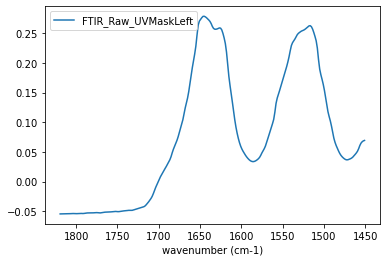

In [15]:
rawData_df.rename(columns={0: "wavenumber (cm-1)", 1: "FTIR_Raw_UVMaskLeft"}, inplace=True)
sample_names = list(rawData_df.columns)[1:]
rawData_df[(rawData_df['wavenumber (cm-1)'] > 1450) & (rawData_df['wavenumber (cm-1)'] < 1820)].plot.line(x='wavenumber (cm-1)', y='FTIR_Raw_UVMaskLeft').invert_xaxis()

## Baseline correction

Rubberband baseline correction was done. The spectra was also trimmed to focus only on the amide I region.

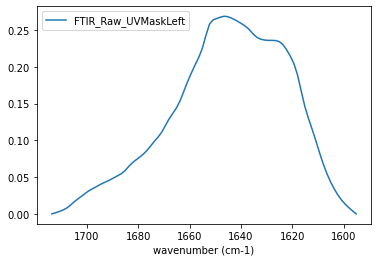

In [63]:
# Jeff (2.27.2022): switched method from 'min' to 'rubberband'
corrected_df = sd_baseline_correction(rawData_df, cols=['FTIR_Raw_UVMaskLeft'], flip=False, method='rubberband', bounds=(1715, 1595)) #(1715, 1595) was (1750, 1550))
corrected_df.plot.line(x='wavenumber (cm-1)', y='FTIR_Raw_UVMaskLeft').invert_xaxis()


In [64]:
corrected_df.columns[1] #only look at first point/column rn (Jeff 2.28.2022)

'FTIR_Raw_UVMaskLeft'

In [65]:
corrected_df[60:-1] #only look at 

,wavenumber (cm-1),FTIR_Raw_UVMaskLeft
60,1627.96740,0.236040
61,1626.53935,0.235841
62,1625.11131,0.234462
63,1623.68327,0.230483
64,1622.25523,0.223545
65,1620.82719,0.215016
66,1619.39915,0.204707
67,1617.97111,0.189219
68,1616.54306,0.167460
69,1615.11502,0.146311


In [66]:
### for testing purposes

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ftir.modeling.peak_definitions import yang_h20_2015
from scipy import optimize
from scipy.spatial import ConvexHull

def gaussian_least_squares_(df, col, peaks= hu_Kaplan_Cebe_2006,
                           peak_width=5, params=dict()): # originally was yang_h20_2015,

    def fun(p, x, y):
        """ Minimizing across parameter space p, for a given range, x"""
        return gaussian_sum(x, *p) - y

    data = np.array(pd.concat([df.iloc[:,0], df[col]], axis=1))
    heights = guess_heights_(df, col, peaks['means'], gain=1.0)
    width = peak_width
    lb = list()
    ub = list()
    guess = list()

    # Make 1-D array for optimization func definition above
    for mean, bound, height in zip(peaks['means'], peaks['uncertainties'],
                                   heights):
        lb.extend([0, bound[0], 0])
        ubh = np.inf if height <= 0 else height
        ub.extend([ubh, bound[1], peak_width*1])
        guess.extend([height*0.95, mean, peak_width])

    args = [fun, np.array(guess)]
    params['args'] = (data[:, 0], data[:, 1])
    params['bounds'] = (np.array(lb), np.array(ub))
    res = optimize.least_squares(*args, **params)

    areas = list()
    for i in range(0, len(res.x), 3):
        height = res.x[i]
        width = res.x[i+2]
        area = gaussian_integral(height, width)
        areas.append(area)
    return areas, res

def guess_heights_(df, col, center_list, gain=0.95):
    """ Determines guesses for the heights based on measured data.

    Function creates an integer mapping to the measured frequencies, and then
    creates an initial peak height guess of gain*actual height at x=freq*. A
    Default of 0.95 seems to work best for most spectra, but can be change to
    improve convergence.

    Parameters
    ----------
    df : Dataframe
        Dataframe containing the measured absorbance data

    col : string or integer
        Column index for the absorbance data being fit. Accepts either index
        or string convention.

    center_list : iterable of integers
        An iterable of integer peak positions used to find the experiment
        absorbance at a given wavenumber. I.e, the heights are returned at the
        center values in this iterable

    gain : number (optional)
        Fraction of the measured absorbance value to use determine the initial
        guess for the peak height. The value Default value is 0.95, and thus
        by default, all initial peak guesses are 95% of the peak max.

    """
    heights = []
    freq_map = {}
    for i in df.iloc[:,0]:
        j = math.floor(i)
        freq_map[j] = float(df[col].get(df.iloc[:,0] == i))
    print(freq_map)
    # pdb.set_trace()
    for i in center_list:
        height = freq_map[i]
        heights.append(gain*height)
    return heights



In [67]:
#local yang list,
yang_list = {
    'means': [1625, 1627, 1633, 1637, 1642, 1649, 1656, 1663, 1667, 1675, 1680,
              1685, 1692, 1696],
    'uncertainties': [(1622, 1625), (1625, 1629), (1631, 1635), (1636, 1640),
                      (1641, 1643), (1646, 1650), (1654, 1658), (1660, 1666),
                      (1666, 1668), (1674, 1676), (1678, 1682), (1683, 1687),
                      (1689, 1693), (1694, 1698)],
    'relative_uncertainties': [1, 2, 2, 2, 1, 2, 2, 3, 1, 1, 2, 2, 2, 2],
    'assignments': ['beta_sheet', 'beta_sheet', 'beta_sheet', '310_helix',
                    'unordered', 'alpha_helix', 'beta_turn', 'beta_turn',
                    'beta_sheet', 'beta_turn', 'beta_turn', 'beta_turn']}
                    
#local 'Cebe is a complete badass woman physicist professor' list 
hu_Kaplan_Cebe_2006 = {
    'means': [1610, 1619, 1625, 1632,  1642, 1652, 1659, 1666, 1679, 1692, 1700],
    'uncertainties': [(1605, 1615), (1616, 1621), (1622,1627),(1628, 1637), (1638, 1646),
                      (1647, 1655), (1656, 1662), (1663, 1670), (1671, 1685),
                      (1686, 1696), (1697, 1703)],
    'relative_uncertainties': [5, 2.5, 2.5, 4.5, 4, 4, 3, 3.5, 7, 5, 3],
    'assignments': ['(Tyr) side chains/aggregate strands', 'aggregate beta-strand/beta_sheet(weak)', 
                    'intermolecular beta_sheet (strong)', 'intramolecular beta_sheet (strong)^b',
                    'random coils/extended', 'random coils', 'alpha-helices', 'turns',
                    'turns', 'turns', 'intermolecular beta_sheets (weak']}

In [140]:
index = 1
sample = corrected_df.columns[index]

#Jeff: 2.28.2022: increased peak width from 1 to 10cm^-1
area, res = gaussian_least_squares(corrected_df, corrected_df.columns[index], peak_width=10, 
                                    peaks=hu_Kaplan_Cebe_2006, params={'loss':'linear'})


In [101]:
print(hu_Kaplan_Cebe_2006['means'][0])
hu_Kaplan_Cebe_2006['assignments'][0]

1610


'(Tyr) side chains/aggregate strands'

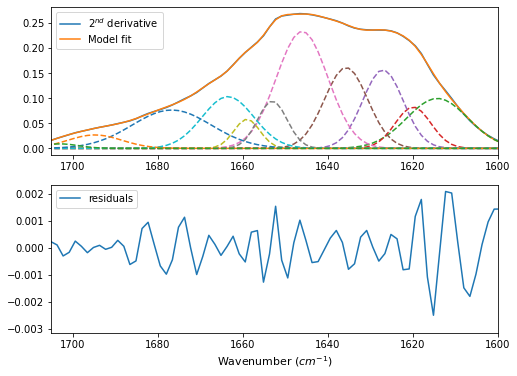

{'random coils': 0.05387248140014399, '(Tyr) side chains/aggregate strands': 0.11734461106283947, 'alpha-helices': 0.02896793197956089, 'intermolecular beta_sheets (weak': 0.006369465974165333, 'random coils/extended': 0.23177334703911778, 'aggregate beta-strand/beta_sheet(weak)': 0.05672511234344763, 'intramolecular beta_sheet (strong)^b': 0.13449479632445893, 'turns': 0.24778159064093008, 'intermolecular beta_sheet (strong)': 0.12267066323533611}


In [141]:
# structs = secondary_structure(area, yang_h20_2015) #works
structs = secondary_structure(area, hu_Kaplan_Cebe_2006)
gaussian_list_data = gaussian_list(corrected_df['wavenumber (cm-1)'], *res.x)
plt = create_fit_plots(corrected_df, sample, gaussian_list_data)

# plt.annotate(hu_Kaplan_Cebe_2006['assignments'][0], xy=(hu_Kaplan_Cebe_2006['means'][0], .003), xytext=(hu_Kaplan_Cebe_2006['means'][0], .01),
#              arrowprops=dict(facecolor='black', shrink=0.5),
#              )
# plt.annotate(hu_Kaplan_Cebe_2006['assignments'][1], xy=(hu_Kaplan_Cebe_2006['means'][1], .003), xytext=(hu_Kaplan_Cebe_2006['means'][1], .01),
#              arrowprops=dict(facecolor='black', shrink=0.5),
#              )


# plt.legend(hu_Kaplan_Cebe_2006['means'],hu_Kaplan_Cebe_2006['assignments'])
plt.show()


print(structs)

In [154]:
#is the second derivative actually being printed?
secondDerivativeData_df=np.diff(rawData_df, n=2, axis=-1)
secondDerivativeData_df
#corrected_df.plot.line(x='wavenumber (cm-1)', y='FTIR_Raw_UVMaskLeft').invert_xaxis()
#secondDerivativeData_df.plot.line(x='wavenumber (cm-1)', y='FTIR_Raw_UVMaskLeft').invert_xaxis()


NameError: name 'size' is not defined

In [ ]:
#figure out how to quantify area under curves, and compare beta sheet vs random coil 

## Poor peak fitting

Poor fitting was observed below 1620, as there is an apparent peak in the data. This is likely a side-chain peak, as several synthetic peptides are used in icatibant. Thus an additional peak was added to the peak definition in order to capture this feature. The peak initial guess was centered around 1610 wavenumbers and had a relatively large uncertainity of 4.

In [58]:
from copy import deepcopy
new_peaks = deepcopy(hu_Kaplan_Cebe_2006)
new_peaks['means'].append(1610)
new_peaks['assignments'].append('side-chain')
new_peaks['uncertainties'].append((1606, 1616))
new_peaks['relative_uncertainties'].append(4)

Analyzing FTIR_Raw_UVMaskLeft


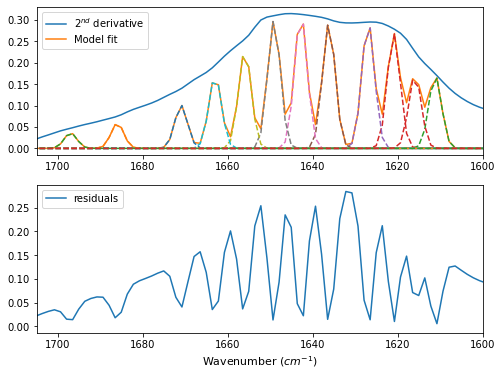

{'random coils': 0.12484975524141058, '(Tyr) side chains/aggregate strands': 0.07073668800246218, 'alpha-helices': 0.09496300547743525, 'side-chain': 0.07073668800246218, 'intermolecular beta_sheets (weak': 0.015063986591305147, 'random coils/extended': 0.13010260313340904, 'aggregate beta-strand/beta_sheet(weak)': 0.11200252868687123, 'intramolecular beta_sheet (strong)^b': 0.12204241373143516, 'turns': 0.1367528832437064, 'intermolecular beta_sheet (strong)': 0.12274944788950304}


In [59]:
index = 1
sample = corrected_df.columns[index]
print("Analyzing {}".format(corrected_df.columns[index]))
area, res = gaussian_least_squares(corrected_df, corrected_df.columns[index], peak_width=1.5, peaks=new_peaks)
structs = secondary_structure(area, new_peaks)
gaussian_list_data = gaussian_list(corrected_df['wavenumber (cm-1)'], *res.x)
plt = create_fit_plots(corrected_df, sample, gaussian_list_data)
plt.show()
print(structs)